In [16]:
import pandas as pd
import numpy as np
from glob import glob 

import cv2
import numpy as np

import pytesseract

"""
POC: Load Analyze-format MRI (.hdr/.img) and HDF5 data in Python
Requires: nibabel, h5py, numpy, matplotlib, pandas
"""

import os
import nibabel as nb
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
from transformers import pipeline
from PIL import Image

In [ ]:
# Load data
data_dir = "./data/"
data_l = glob(data_dir + '*.csv')
print(data_l)

event_df = pd.read_csv(data_l[0])
eye_track_df = pd.read_csv(data_l[1])
motion_df = pd.read_csv(data_l[2])

# Monkey K2 (Kuma)
# Electrodes [52 -> 64] and [121 -> 128] (inclusive) are in the medial wall of the macaque brain.
ecog_df = pd.read_csv(data_l[3])


['./data/Event.csv', './data/EyeTrack.csv', './data/Motion.csv', './data/ECoG.csv']


In [18]:
print(event_df)

    EventTime  EventData  EventIndex
0       1.994          1           1
1       5.656          2           5
2     477.235          3         477
3     480.288          4         480
4     784.158          1         784
5     787.462          2         787
6    1292.233          3        1292
7    1295.411          4        1295
8    1770.277          5        1770
9    1773.972          6        1773
10   2227.700          7        2227
11   2231.237          8        2231
12   2559.448          5        2559
13   2563.069          6        2563
14   3034.857          7        3034
15   3038.360          8        3038
16   3477.908          9        3477
17   3480.527         10        3480


In [15]:
motion_df["Kuma10mks_HeadSquare:LSHOz"]

0         174.46144
1         174.45848
2         174.47888
3         174.44635
4         174.41740
            ...    
443246    178.61717
443247    178.62839
443248    178.61504
443249    178.65863
443250    178.65982
Name: Kuma10mks_HeadSquare:LSHOz, Length: 443251, dtype: float64

In [11]:
motion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443251 entries, 0 to 443250
Data columns (total 67 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   MotionTime                         443251 non-null  float64
 1   Kuma10mks_HeadSquare:LSHOx         443251 non-null  float64
 2   Kuma10mks_HeadSquare:LSHOy         443251 non-null  float64
 3   Kuma10mks_HeadSquare:LSHOz         443251 non-null  float64
 4   Kuma10mks_HeadSquare:LELBx         443250 non-null  float64
 5   Kuma10mks_HeadSquare:LELBy         443250 non-null  float64
 6   Kuma10mks_HeadSquare:LELBz         443250 non-null  float64
 7   Kuma10mks_HeadSquare:LWRIx         443251 non-null  float64
 8   Kuma10mks_HeadSquare:LWRIy         443251 non-null  float64
 9   Kuma10mks_HeadSquare:LWRIz         443251 non-null  float64
 10  Kuma10mks_HeadSquare:RSHOx         443251 non-null  float64
 11  Kuma10mks_HeadSquare:RSHOy         4432

In [21]:
print(ecog_df["ECoG_ch1"])

0         -105
1         -125
2         -102
3         -109
4         -101
          ... 
3697427     82
3697428     71
3697429     42
3697430     70
3697431     83
Name: ECoG_ch1, Length: 3697432, dtype: int64


## Extracting centroids of ECoG array

In [10]:
image_path = "./imgs/K2.png"

In [11]:
raw_image = Image.open(image_path)

In [ ]:
# segment_anything_pipeline = pipeline("mask-generation", model="Zigeng/SlimSAM-uniform-77")

In [ ]:
# output = segment_anything_pipeline(raw_image, points_per_batch=32)

In [ ]:
# def extract_centroids(image_path):
#     # Read the image
#     image = cv2.imread(image_path)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

#     # Use HoughCircles to detect circles in the image
#     circles = cv2.HoughCircles(
#         gray, 
#         cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
#         param1=50, param2=30, minRadius=10, maxRadius=100
#     )

#     # If circles are detected
#     if circles is not None:
#         circles = np.round(circles[0, :]).astype("int")  # Convert to integer

#         centroids = []
#         for circle in circles:
#             x, y, r = circle
#             centroids.append((x, y))
#             # Draw the circle and center on the image (optional for visualization)
#             cv2.circle(image, (x, y), r, (0, 255, 0), 4)  # Green circle
#             cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # Red center
#         # Show the image with detected circles (optional)
#         cv2.imshow("Detected Circles", image)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         return centroids
#     else:
#         print("No circles were detected.")
#         return []

# # Example usage
# image_path = "./imgs/K2.png"
# centroids = extract_centroids(image_path)
# print("Centroid Coordinates:", centroids)


# Sulci Notes:
Sulci from right to left
1. Principal Sulcus (25 is at the principal sulcus)
2. Arcuate Sulcus
3. Central Sulcus
4. Intraparietal Sulcus
5. Lateral Sulcus or Sylvian Fissure (21 is at the conjunction of Superior Temporal Sulcus and Lateral Sulcus)
6. Superior Temporal Sulcus
7. Lunate Sulcus
8. Unknown. Possibly Calcarine Sulcus.

# MRI data

In [12]:

# ─────────────────────────────────────────────────────────────────────────────
# 1. Paths (edit these to your local files)
# ─────────────────────────────────────────────────────────────────────────────
analyze_hdr = "./data/mri/K2_t1.hdr"   # header for Analyze 7.5
# analyze_img = "./data/mri/K2_t1.img"   # binary data file



# ─────────────────────────────────────────────────────────────────────────────
# 2. Load Analyze-format volume with NiBabel
# ─────────────────────────────────────────────────────────────────────────────
# NiBabel will read the header and image automatically from the .hdr/.img pair.
mri_img = nb.load(analyze_hdr)             # you can equally pass analyze_img here
mri_data = mri_img.get_fdata(dtype=np.float32)
print(f"Analyze volume shape: {mri_data.shape}")
print(f"Affine transform (vox→mm):\n{mri_img.affine}")


sagittal_slice = mri_data[mri_data.shape[0]//2, : ,:]
left_lateral_view = np.flip(sagittal_slice, axis=0)

plt.imshow(left_lateral_view.T, cmap="gray", origin="lower")
plt.title("Right Lateral View")

plt.colorbar()
plt.show()


Analyze volume shape: (256, 256, 256)
Affine transform (vox→mm):
[[ -0.5    0.     0.    63.75]
 [  0.     0.5    0.   -63.75]
 [  0.     0.     0.5  -63.75]
 [  0.     0.     0.     1.  ]]


<IPython.core.display.Javascript object>

In [13]:
# Display a middle axial slice
mid_z = mri_data.shape[2] // 2
plt.figure(figsize=(6,6))
plt.imshow(mri_data[:, :, mid_z].T, origin="lower", cmap="gray")
plt.title("Middle axial slice of Analyze volume")
plt.axis("off")
plt.show()


<IPython.core.display.Javascript object>

In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# 4. Summarize intensity distribution with pandas
# ─────────────────────────────────────────────────────────────────────────────
flat = mri_data.flatten()
stats = {
    "minimum": flat.min(),
    "maximum": flat.max(),
    "mean":    flat.mean(),
    "stddev":  flat.std()
}
df = pd.DataFrame(stats, index=["AnalyzeVolume"])
print("\nIntensity summary:")
print(df.to_string())

# ─────────────────────────────────────────────────────────────────────────────
# End of proof-of-concept
# ─────────────────────────────────────────────────────────────────────────────



Intensity summary:
               minimum  maximum        mean       stddev
AnalyzeVolume     77.0  32767.0  3265.28418  5279.571777


## Creating a 3D trajectory animation to identify the meaning of the coordinates

In [5]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Dummy 3D trajectory
n_frames = 100
xs = np.linspace(0, 10, n_frames)
ys = np.sin(xs)
zs = np.cos(xs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
point, = ax.plot([], [], [], 'ro') # single 3D point

def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(-1.1, 1.1)
    ax.set_zlim(-1.1, 1.1)
    return point,

def update(frame):
    point.set_data(xs[frame], ys[frame])
    point.set_3d_properties(zs[frame])
    return point,

ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=False)

plt.show()


<IPython.core.display.Javascript object>

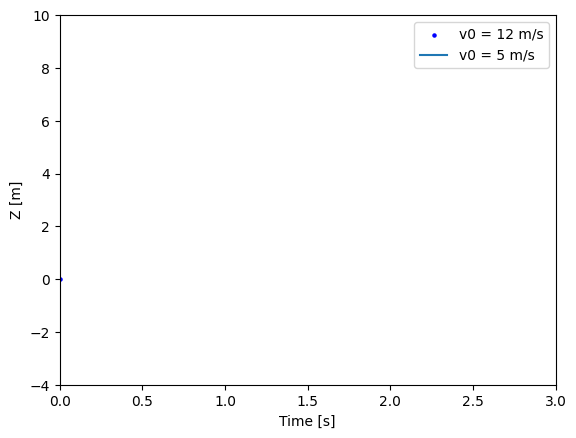

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


# Identifying where the centroids of the ecog array are placed

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Paths: replace these with your actual files
# ─────────────────────────────────────────────────────────────────────────────
# mri_nii   = "./path/to/preop_T1.nii.gz"       # your subject’s structural MRI
ct_nii    = "./imgs/K2.png" # "/path/to/postop_CT_with_ECoG.nii.gz"
atlas_nii = "./data/atlas/D99_v2.0_dist/D99_atlas_v2.0.nii.gz"  # e.g. CHARM or D99
labels_txt = "./data/atlas/D99_v2.0_dist/D99_v2.0_labels_semicolon.txt"
labels_csv= "./data/atlas/D99_v2.0_dist/D99_v2.0_labels_semicolon.csv"           # CSV: {index,label_name}


In [ ]:
# Converting text file to csv
# df = pd.read_csv(labels_txt, sep=";")
# df.to_csv(labels_csv)

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 2. Load images
# ─────────────────────────────────────────────────────────────────────────────
mri_img   = nb.load(analyze_hdr)
# ct_img    = nb.load(ct_nii)
atlas_img = nb.load(atlas_nii)

mri_data   = mri_img.get_fdata()
# ct_data    = ct_img.get_fdata()
atlas_data = atlas_img.get_fdata().astype(int)

In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 3. Rigid-coregistration: estimate affine from CT → MRI
#    (In practice you’d do this once in ANTs or FSL and save the transform;
#     here we show a simple mutual-information based init from nibabel’s example)
# ─────────────────────────────────────────────────────────────────────────────
from nibabel.processing import resample_from_to
# Resample CT into MRI space (nearest for electrodes)
ct2mri = resample_from_to(ct_img, mri_img, order=0)  # order=0 preserves labels
ct2mri_data = ct2mri.get_fdata()

# ─────────────────────────────────────────────────────────────────────────────
# 4. Segment electrodes in CT (thresholding bright contacts),
#    find their centroids in MRI space
# ─────────────────────────────────────────────────────────────────────────────
# set a threshold high enough to isolate electrodes
thr = np.percentile(ct2mri_data[ct2mri_data>0], 99.5)
bw  = ct2mri_data > thr

# label connected components and compute centroids
labeled, n_labels = ndimage.label(bw)
objects = ndimage.find_objects(labeled)
centroids = []
for label_idx in range(1, n_labels+1):
    coords = np.argwhere(labeled == label_idx)
    if coords.size == 0:
        continue
    # mean in voxel space
    centroid_vox = coords.mean(axis=0)
    # convert to world
    centroid_mri = nb.affines.apply_affine(mri_img.affine, centroid_vox[::-1])
    centroids.append(centroid_mri)
centroids = np.array(centroids)

# ─────────────────────────────────────────────────────────────────────────────
# 5. Map each centroid into atlas indices and lookup label
# ─────────────────────────────────────────────────────────────────────────────
# Invert atlas affine
inv_atlas_affine = np.linalg.inv(atlas_img.affine)
labels = []
for xyz in centroids:
    vox = nb.affines.apply_affine(inv_atlas_affine, xyz)[::-1]
    vox = np.round(vox).astype(int)
    # guard against out-of-bounds:
    if np.any(vox < 0) or vox[0]>=atlas_data.shape[0] or vox[1]>=atlas_data.shape[1] or vox[2]>=atlas_data.shape[2]:
        labels.append("out_of_brain")
    else:
        lbl_idx = int(atlas_data[tuple(vox)])
        labels.append(lbl_idx)

# load your CSV of index→region
import csv
idx2name = {}
with open(labels_csv) as f:
    reader = csv.reader(f)
    for idx,name in reader:
        idx2name[int(idx)] = name

# translate indices to names
region_names = [idx2name.get(i, "unknown") for i in labels]

# ─────────────────────────────────────────────────────────────────────────────
# 6. Print out electrode → region table
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
df = pd.DataFrame({
    "electrode_id": np.arange(len(centroids)) + 1,
    "x_mm": np.round(centroids[:,0],1),
    "y_mm": np.round(centroids[:,1],1),
    "z_mm": np.round(centroids[:,2],1),
    "atlas_index": labels,
    "region": region_names
})
print(df.to_string(index=False))

# ─────────────────────────────────────────────────────────────────────────────
# 7. (Optional) Quick coronal slice with electrodes overlaid
# ─────────────────────────────────────────────────────────────────────────────
slice_z = int(mri_data.shape[2]//2)
plt.imshow(mri_data[:,:,slice_z].T, cmap="gray", origin="lower")
pts = []
for (x,y,z), name in zip(centroids, region_names):
    if abs(z - nb.affines.apply_affine(mri_img.affine,[0,0,slice_z])[2])<2:
        pts.append((x, y))
xs, ys = zip(*pts)
plt.scatter(xs, ys, s=30, c="red")
plt.title("Coronal slice with detected ECoG centroids")
plt.show()
